# Clustering, Modeling and Visualizing Features

We will be using a 1700+ row dataset collected from the Spotify API and consisting of songs from a playlist from DJ and producer Four Tet, which can be found in the above CSV file. The dataset consists of descriptive metadata (track name, artist name) as well as numerical audio features which we will use for modeling (acousticness, danceability, duration, energy, instrumentalness, liveness, loudness, tempo and valence).

After fitting our model we will test it on two additional smaller playlists: Spotify's "Songs to Sing in the Shower" (200 rows) and Max Richter's "Kitchen Playlist" (78 songs).

Below we will import modules to be used.

In [44]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, roc_curve, auc, classification_report, roc_auc_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import six
import sys
sys.modules['sklearn.externals.six'] = six
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from sklearn.utils import _safe_indexing
sys.modules['sklearn.utils.safe_indexing'] = sklearn.utils._safe_indexing
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
%matplotlib inline
from lime import lime_tabular
import warnings
warnings.filterwarnings("ignore")

In [45]:
df = pd.read_csv('fourtet.csv')
df.head()

,Unnamed: 0,track_name,album,artist_name,release_date,duration_ms,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0,Tite,AGO,Nana Benz du Togo,2023-06-16,291454,29,0.871,0.00936,0.505,0.000003,0.0672,-4.200,0.0615,130.282,0.674
1,1,Shella Verse,Shella Verse,Sammy Virji,2023-06-30,163934,57,0.662,0.00632,0.904,0.002190,0.1140,-3.749,0.2860,133.455,0.850
2,2,I Love The Reggay,Out Of Many - 50 Years Of Reggae Music,Various Artists,2012-07-30,161986,29,0.527,0.66500,0.726,0.000003,0.1380,-7.206,0.1350,80.194,0.683
3,3,Early Morning,Troyka,Troyka,1970,233693,24,0.687,0.67300,0.167,0.688000,0.0589,-18.712,0.0500,75.394,0.396
4,4,The First Time Ever I Saw Your Face - 2015 Rem...,Jack Orion,Bert Jansch,1966-09-01,105874,30,0.409,0.74800,0.164,0.911000,0.1060,-16.910,0.1190,201.343,0.244


Importing DataFrame and checking for null values and descriptive statistics.

In [46]:
df.isna().sum()

Unnamed: 0          0
track_name          0
album               0
artist_name         0
release_date        0
duration_ms         0
popularity          0
danceability        0
acousticness        0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
dtype: int64

In [47]:
df.describe()

,Unnamed: 0,duration_ms,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,2021.000000,2.021000e+03,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000
mean,1010.000000,2.995098e+05,12.336962,0.575223,0.417963,0.538206,0.509591,0.161182,-12.454230,0.095026,119.529689,0.424380
std,583.556767,1.736537e+05,15.546887,0.202826,0.368851,0.259359,0.388373,0.133765,5.645329,0.107477,27.608405,0.272857
min,0.000000,1.388600e+04,0.000000,0.000000,0.000002,0.000281,0.000000,0.020600,-38.237000,0.000000,0.000000,0.000000
25%,505.000000,1.920000e+05,0.000000,0.427000,0.042400,0.341000,0.022100,0.090400,-15.230000,0.039900,100.006000,0.181000
50%,1010.000000,2.688640e+05,6.000000,0.601000,0.325000,0.564000,0.668000,0.111000,-11.227000,0.055500,121.995000,0.397000
75%,1515.000000,3.637060e+05,20.000000,0.745000,0.799000,0.752000,0.881000,0.170000,-8.413000,0.096900,134.277000,0.653000
max,2020.000000,2.241200e+06,80.000000,0.980000,0.996000,0.999000,0.984000,0.993000,-1.987000,0.947000,217.744000,0.996000


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2021 entries, 0 to 2020
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        2021 non-null   int64  
 1   track_name        2021 non-null   object 
 2   album             2021 non-null   object 
 3   artist_name       2021 non-null   object 
 4   release_date      2021 non-null   object 
 5   duration_ms       2021 non-null   int64  
 6   popularity        2021 non-null   int64  
 7   danceability      2021 non-null   float64
 8   acousticness      2021 non-null   float64
 9   energy            2021 non-null   float64
 10  instrumentalness  2021 non-null   float64
 11  liveness          2021 non-null   float64
 12  loudness          2021 non-null   float64
 13  speechiness       2021 non-null   float64
 14  tempo             2021 non-null   float64
 15  valence           2021 non-null   float64
dtypes: float64(9), int64(3), object(4)
memory 

Not being an audio feature, we can drop the 'popularity' column.

In [49]:
df = df.drop(['popularity', 'Unnamed: 0'], axis=1)
df

,track_name,album,artist_name,release_date,duration_ms,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,Tite,AGO,Nana Benz du Togo,2023-06-16,291454,0.871,0.00936,0.50500,0.000003,0.0672,-4.200,0.0615,130.282,0.674
1,Shella Verse,Shella Verse,Sammy Virji,2023-06-30,163934,0.662,0.00632,0.90400,0.002190,0.1140,-3.749,0.2860,133.455,0.850
2,I Love The Reggay,Out Of Many - 50 Years Of Reggae Music,Various Artists,2012-07-30,161986,0.527,0.66500,0.72600,0.000003,0.1380,-7.206,0.1350,80.194,0.683
3,Early Morning,Troyka,Troyka,1970,233693,0.687,0.67300,0.16700,0.688000,0.0589,-18.712,0.0500,75.394,0.396
4,The First Time Ever I Saw Your Face - 2015 Rem...,Jack Orion,Bert Jansch,1966-09-01,105874,0.409,0.74800,0.16400,0.911000,0.1060,-16.910,0.1190,201.343,0.244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,Es war einmal,Sowiesoso,Cluster,1976,325400,0.643,0.75800,0.15600,0.976000,0.1040,-20.074,0.0419,117.372,0.314
2017,Kinoshita,Eph Reissue,Fridge,2002-05-07,302693,0.623,0.13200,0.94500,0.895000,0.3020,-5.775,0.0984,139.971,0.611
2018,Promises Of Fertility,For Those Of You Who Have Never (And Also Thos...,Huerco S.,2016-06-10,415933,0.260,0.82100,0.28400,0.841000,0.1100,-19.656,0.0367,61.829,0.425
2019,3,Get Out,Pita,2008-05-12,678080,0.228,0.00869,0.61900,0.928000,0.1540,-7.414,0.0483,105.538,0.207


We will select our numerical values for modeling and store them in the variable X.

In [50]:
X = df.select_dtypes(np.number)
X

,duration_ms,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,291454,0.871,0.00936,0.50500,0.000003,0.0672,-4.200,0.0615,130.282,0.674
1,163934,0.662,0.00632,0.90400,0.002190,0.1140,-3.749,0.2860,133.455,0.850
2,161986,0.527,0.66500,0.72600,0.000003,0.1380,-7.206,0.1350,80.194,0.683
3,233693,0.687,0.67300,0.16700,0.688000,0.0589,-18.712,0.0500,75.394,0.396
4,105874,0.409,0.74800,0.16400,0.911000,0.1060,-16.910,0.1190,201.343,0.244
...,...,...,...,...,...,...,...,...,...,...
2016,325400,0.643,0.75800,0.15600,0.976000,0.1040,-20.074,0.0419,117.372,0.314
2017,302693,0.623,0.13200,0.94500,0.895000,0.3020,-5.775,0.0984,139.971,0.611
2018,415933,0.260,0.82100,0.28400,0.841000,0.1100,-19.656,0.0367,61.829,0.425
2019,678080,0.228,0.00869,0.61900,0.928000,0.1540,-7.414,0.0483,105.538,0.207


With KMeans we can find the optimal number of clusters using the elbow method.

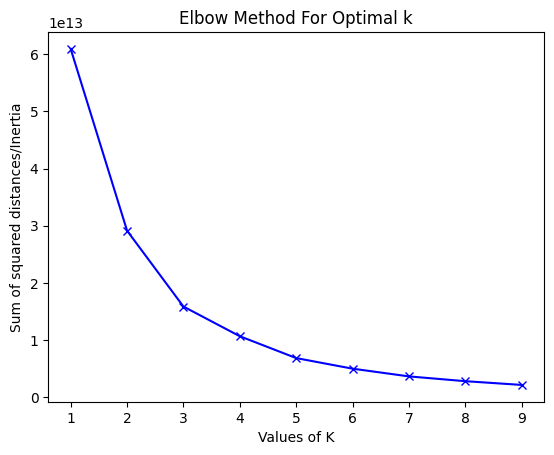

In [51]:
sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(X)
 sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

It appears the optimal K is right around 3 so we will scale and fit our numeric data.

In [52]:
cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=3, verbose=2))])
cluster_pipeline.fit(X)

Initialization complete
Iteration 0, inertia 19027.399750962857.
Iteration 1, inertia 14653.954662911232.
Iteration 2, inertia 14248.644947266372.
Iteration 3, inertia 14166.807216383964.
Iteration 4, inertia 14142.137733663312.
Iteration 5, inertia 14133.290321918756.
Iteration 6, inertia 14131.396551091704.
Iteration 7, inertia 14131.213124079983.
Iteration 8, inertia 14131.131224911442.
Converged at iteration 8: center shift 2.6648836444079452e-05 within tolerance 0.00010000000000000005.
Initialization complete
Iteration 0, inertia 20154.061426539938.
Iteration 1, inertia 15086.939826595279.
Iteration 2, inertia 14992.377771681684.
Iteration 3, inertia 14938.002382845436.
Iteration 4, inertia 14871.820911120827.
Iteration 5, inertia 14782.519775368644.
Iteration 6, inertia 14645.429878972136.
Iteration 7, inertia 14489.371450782142.
Iteration 8, inertia 14353.902020218544.
Iteration 9, inertia 14244.819166348327.
Iteration 10, inertia 14174.903109085484.
Iteration 11, inertia 14143.

Pipeline(steps=[('scaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3, verbose=2))])

In [53]:
cluster_labels = cluster_pipeline.predict(X)
df['cluster'] = cluster_labels
df['cluster'].value_counts()

1    758
0    638
2    625
Name: cluster, dtype: int64

We have three similarly sized clusters. We can reduce dimentionality using Principal Component Analysis, fit and visualize our data using a Plotly hover plot. 

In [54]:
pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding = pca_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)
projection['title'] = df['track_name']
projection['artist'] = df['artist_name']
projection['cluster'] = df['cluster']
projection

,x,y,title,artist,cluster
0,-2.117849,-0.426114,Tite,Nana Benz du Togo,2
1,-2.975828,-1.654779,Shella Verse,Sammy Virji,2
2,-0.533244,-1.892023,I Love The Reggay,Various Artists,2
3,1.828943,-0.093287,Early Morning,Troyka,0
4,1.622131,0.851519,The First Time Ever I Saw Your Face - 2015 Rem...,Bert Jansch,0
...,...,...,...,...,...
2016,1.994681,0.896696,Es war einmal,Cluster,0
2017,-2.088406,0.516562,Kinoshita,Fridge,1
2018,2.753807,0.248925,Promises Of Fertility,Huerco S.,0
2019,-0.039047,2.008334,3,Pita,1


In [55]:
fig = px.scatter(projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'title', 'artist'])
fig.show()

We can proceed to build a content-based recommendation system, however let's repeat the process with two clusters and visualize our results to see if we can build a clasifier and identify the model's most important features.

In [56]:
cluster_pipeline2 = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=2, verbose=2))])
cluster_pipeline2.fit(X)

Initialization complete
Iteration 0, inertia 26716.320393575046.
Iteration 1, inertia 15904.853596522345.
Iteration 2, inertia 15804.749452872768.
Iteration 3, inertia 15801.683621465181.
Iteration 4, inertia 15801.58503203337.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 22920.295921068384.
Iteration 1, inertia 15850.263109675809.
Iteration 2, inertia 15811.097028844677.
Iteration 3, inertia 15802.577812170248.
Iteration 4, inertia 15801.6422518451.
Converged at iteration 4: center shift 6.841025595710512e-05 within tolerance 0.00010000000000000005.
Initialization complete
Iteration 0, inertia 22374.53124859543.
Iteration 1, inertia 15868.895379271724.
Iteration 2, inertia 15819.738158183696.
Iteration 3, inertia 15807.892824770894.
Iteration 4, inertia 15802.998130253662.
Iteration 5, inertia 15801.79582267633.
Iteration 6, inertia 15801.605924581769.
Converged at iteration 6: center shift 2.4955200286721972e-05 within tolerance 0.0001000

Pipeline(steps=[('scaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=2, verbose=2))])

In [57]:
cluster_labels2 = cluster_pipeline2.predict(X)
df['cluster2'] = cluster_labels2
df['cluster2'].value_counts()

1    1320
0     701
Name: cluster2, dtype: int64

In [58]:
pca_pipeline2 = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding2 = pca_pipeline2.fit_transform(X)
projection2 = pd.DataFrame(columns=['x', 'y'], data=song_embedding2)
projection2['title'] = df['track_name']
projection2['artist'] = df['artist_name']
projection2['cluster2'] = df['cluster2']
projection2

,x,y,title,artist,cluster2
0,-2.117849,-0.426114,Tite,Nana Benz du Togo,1
1,-2.975828,-1.654779,Shella Verse,Sammy Virji,1
2,-0.533244,-1.892023,I Love The Reggay,Various Artists,1
3,1.828943,-0.093287,Early Morning,Troyka,0
4,1.622131,0.851519,The First Time Ever I Saw Your Face - 2015 Rem...,Bert Jansch,0
...,...,...,...,...,...
2016,1.994681,0.896696,Es war einmal,Cluster,0
2017,-2.088406,0.516562,Kinoshita,Fridge,1
2018,2.753807,0.248925,Promises Of Fertility,Huerco S.,0
2019,-0.039047,2.008334,3,Pita,1


In [59]:
fig2 = px.scatter(projection2, x='x', y='y', color='cluster2', hover_data=['x', 'y', 'title', 'artist'])
fig2.show()

While our sample sizes are imbalanced, our cluster on the positive x-axis remains similar. A binary classification model focusing on accuracy can pinpoint which audio features are most important.

In [60]:
# Creating x and y variables, keeping numerical features only 
predictor_x = df.drop(columns=['track_name', 'album', 'artist_name', 'release_date', 'tempo', 'cluster', 'cluster2'], axis=1)
predictor_y = df.cluster2

In [61]:
def print_metrics(labels, preds):
    
    # Function to easily print results of training and test metrics
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

In [62]:
# Creating train and test sets, scaling and using SMOTE to adjust for imbalanced samples
X_train, X_test, y_train, y_test = train_test_split(predictor_x, predictor_y, test_size=.25,  random_state=42)
scaler = StandardScaler()
smote = SMOTE()

# Using Logistic Regression in pipeline to fit resampled sets
logreg = LogisticRegression(fit_intercept=False, solver='liblinear')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
pipeline = make_pipeline(scaler, smote, logreg)
pipeline.fit(X_train_resampled, y_train_resampled)
train_pred = pipeline.predict(X_train_resampled)
test_pred = pipeline.predict(X_test)

# ROC AUC score and classification metrics followed by visualized confusion matrix
train_score = roc_auc_score(y_train_resampled, train_pred)
test_score = roc_auc_score(y_test, test_pred)
print("Training Score: ", train_score)
print("Test Score: ", test_score)

Training Score:  0.986322188449848
Test Score:  0.9647537711121525


In [63]:
print("Training Metrics")
print(print_metrics(y_train_resampled, train_pred))
print('\n')
print("Testing Metrics")
print(print_metrics(y_test, test_pred))

Training Metrics
Precision Score: 0.9809619238476954
Recall Score: 0.9918946301925026
Accuracy Score: 0.986322188449848
F1 Score: 0.98639798488665
None


Testing Metrics
Precision Score: 0.9787878787878788
Recall Score: 0.96996996996997
Accuracy Score: 0.9664031620553359
F1 Score: 0.9743589743589743
None


In [64]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': logreg.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

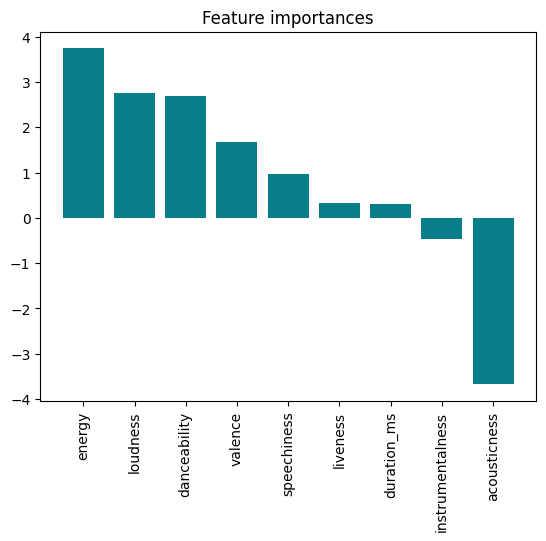

In [65]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances', size=12)
plt.xticks(rotation='vertical')
plt.show()

In [66]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['0', '1'],
    mode='classification'
)

In [67]:
exp = explainer.explain_instance(
    data_row=X_test.iloc[0], 
    predict_fn=pipeline.predict_proba
)

In [68]:
exp.show_in_notebook(show_table=True)

We will test the model on two additional playlists.  First is Spotify's own "Songs to Sing in the Shower" playlist consisting of 200 songs. Following that will be Max Richter's classical-themed "Kitchen Playlist."

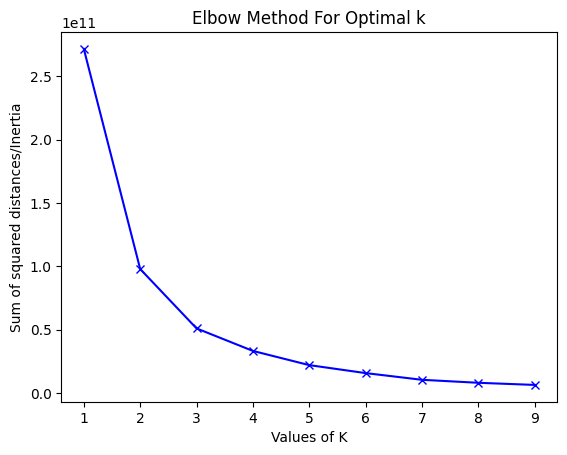

In [69]:
df_shower = pd.read_csv('showersongs.csv')
df_shower = df_shower.drop(['popularity', 'Unnamed: 0'], axis=1)
X_shower = df_shower.select_dtypes(np.number)
sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(X_shower)
 sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [70]:
cluster_pipeline3 = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=2))])
cluster_pipeline3.fit(X_shower)

Pipeline(steps=[('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=2))])

In [71]:
cluster_labels3 = cluster_pipeline3.predict(X_shower)
df_shower['cluster'] = cluster_labels3
df_shower['cluster'].value_counts()

0    139
1     61
Name: cluster, dtype: int64

In [72]:
pca_pipeline3 = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding3 = pca_pipeline3.fit_transform(X_shower)
projection3 = pd.DataFrame(columns=['x', 'y'], data=song_embedding3)
projection3['title'] = df_shower['track_name']
projection3['artist'] = df_shower['artist_name']
projection3['cluster'] = df_shower['cluster']
fig3 = px.scatter(projection3, x='x', y='y', color='cluster', hover_data=['x', 'y', 'title', 'artist'])
fig3.show()

Although there are less data points here, a two-cluster model seems to work best.

In [73]:
# Creating x and y variables, keeping numerical features only 
predictor_x = df_shower.drop(columns=['track_name', 'album', 'artist_name', 'release_date', 'tempo', 'cluster'], axis=1)
predictor_y = df_shower.cluster

# Creating train and test sets, scaling and using SMOTE to adjust for imbalanced samples
X_train, X_test, y_train, y_test = train_test_split(predictor_x, predictor_y, test_size=.25,  random_state=42)
scaler = StandardScaler()

# Using Logistic Regression in pipeline to fit resampled sets
logreg = LogisticRegression(fit_intercept=False, solver='liblinear')
pipeline = make_pipeline(scaler, logreg)
pipeline.fit(X_train, y_train)
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

# ROC AUC score and classification metrics followed by visualized confusion matrix
train_score = roc_auc_score(y_train, train_pred)
test_score = roc_auc_score(y_test, test_pred)
print("Training Score: ", train_score)
print("Test Score: ", test_score)

Training Score:  0.9747474747474748
Test Score:  0.9500000000000001


In [74]:
print("Training Metrics")
print(print_metrics(y_train, train_pred))
print('\n')
print("Testing Metrics")
print(print_metrics(y_test, test_pred))

Training Metrics
Precision Score: 0.9107142857142857
Recall Score: 1.0
Accuracy Score: 0.9666666666666667
F1 Score: 0.9532710280373832
None


Testing Metrics
Precision Score: 0.7142857142857143
Recall Score: 1.0
Accuracy Score: 0.92
F1 Score: 0.8333333333333333
None


In [75]:
# print("Confusion Matrices - Training and Test Sets")
# plot_confusion_matrix(pipeline, X_train, y_train, cmap=plt.cm.Blues, values_format='.3g')
# plot_confusion_matrix(pipeline, X_test, y_test, cmap=plt.cm.Blues, values_format='.3g')

In [76]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': logreg.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

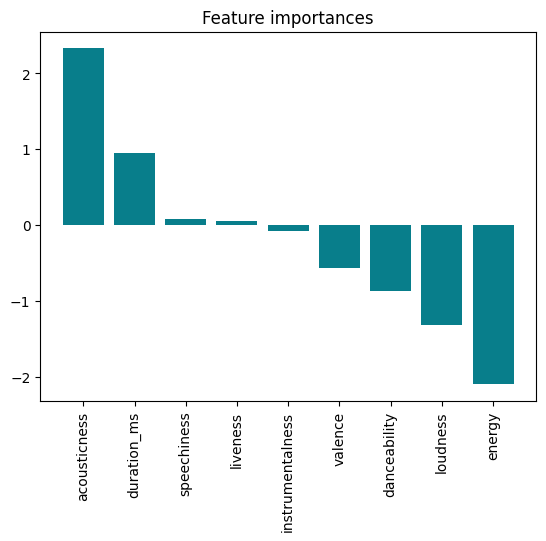

In [77]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances', size=12)
plt.xticks(rotation='vertical')
plt.show()

Despite the differences, our feature importances remain similar.

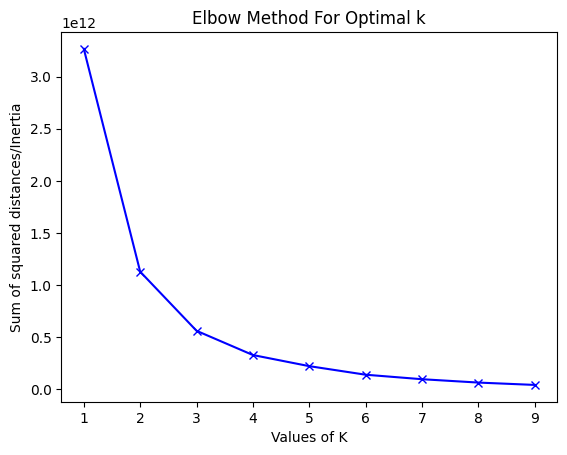

In [78]:
df_max = pd.read_csv('maxrichter.csv')
df_max = df_max.drop(['popularity', 'Unnamed: 0'], axis=1)
X_max = df_max.select_dtypes(np.number)
sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(X_max)
 sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [79]:
cluster_pipeline4 = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=2))])
cluster_pipeline4.fit(X_max)

Pipeline(steps=[('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=2))])

In [80]:
cluster_labels4 = cluster_pipeline4.predict(X_max)
df_max['cluster'] = cluster_labels4
df_max['cluster'].value_counts()

0    60
1    18
Name: cluster, dtype: int64

In [81]:
pca_pipeline4 = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding4 = pca_pipeline4.fit_transform(X_max)
projection4 = pd.DataFrame(columns=['x', 'y'], data=song_embedding4)
projection4['title'] = df_max['track_name']
projection4['artist'] = df_max['artist_name']
projection4['cluster'] = df_max['cluster']
fig4 = px.scatter(projection4, x='x', y='y', color='cluster', hover_data=['x', 'y', 'title', 'artist'])
fig4.show()

In [82]:
# Creating x and y variables, keeping numerical features only 
predictor_x = df_max.drop(columns=['track_name', 'album', 'artist_name', 'release_date', 'tempo', 'cluster'], axis=1)
predictor_y = df_max.cluster

# Creating train and test sets, scaling and using SMOTE to adjust for imbalanced samples
X_train, X_test, y_train, y_test = train_test_split(predictor_x, predictor_y, test_size=.25,  random_state=42)
scaler = StandardScaler()

# Using Logistic Regression in pipeline to fit resampled sets
logreg = LogisticRegression(fit_intercept=False, solver='liblinear')
pipeline = make_pipeline(scaler, logreg)
pipeline.fit(X_train, y_train)
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

# ROC AUC score and classification metrics followed by visualized confusion matrix
train_score = roc_auc_score(y_train, train_pred)
test_score = roc_auc_score(y_test, test_pred)
print("Training Score: ", train_score)
print("Test Score: ", test_score)

Training Score:  0.9659090909090909
Test Score:  0.9375


In [83]:
print("Training Metrics")
print(print_metrics(y_train, train_pred))
print('\n')
print("Testing Metrics")
print(print_metrics(y_test, test_pred))

Training Metrics
Precision Score: 0.8235294117647058
Recall Score: 1.0
Accuracy Score: 0.9482758620689655
F1 Score: 0.9032258064516129
None


Testing Metrics
Precision Score: 0.6666666666666666
Recall Score: 1.0
Accuracy Score: 0.9
F1 Score: 0.8
None


In [84]:
# print("Confusion Matrices - Training and Test Sets")
# plot_confusion_matrix(pipeline, X_train, y_train, cmap=plt.cm.Blues, values_format='.3g')
# plot_confusion_matrix(pipeline, X_test, y_test, cmap=plt.cm.Blues, values_format='.3g')

In [85]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': logreg.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

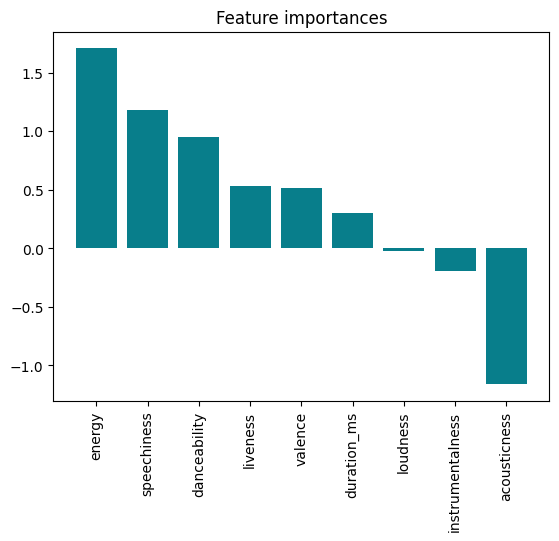

In [86]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances', size=12)
plt.xticks(rotation='vertical')
plt.show()

There are slight differences in feature importance here; this playlist is much shorter however a content-based recommendation system should still work despite the difference in recommended clusters.